In [ ]:
# mount google drive (not necessary)
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/ML/innovation_lab

Mounted at /content/drive
/content/drive/MyDrive/ML/innovation_lab


In [ ]:
"""
LOADING OUR REVIEW DATASET
"""

import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tag import pos_tag
import re
import pandas as pd
import numpy as np
import string
import math


r_df = pd.read_csv('/content/drive/MyDrive/ML/innovation_lab/Final_review_dataset.csv', encoding= 'unicode_escape') # SOURCE PATH TO REVIEW DATASET
# print(r_df)

c_df = r_df.copy(deep=True)
c_df=c_df.drop_duplicates(subset='Text', keep="last")
c_df=c_df.reset_index(drop=True)
print(c_df)

const_list=[]
for row in range(len(c_df['Target'])):
  if c_df['Target'][row]=='C':
    const_list.append(row)
print(const_list)
print("\nconstructive reviews: {} \nnon-constructive reviews: {}".format(len(const_list),len(c_df['Target'])-len(const_list)))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
                                                   Text Target
0     I don't see how your approach has potential to...      N
1     It is a bit strange for me that authors have u...      C
2     The paper could be considered for acceptance g...      C
3     Reviewer 2: The proposal is also poorly writte...      N
4     The scientific contri

In [ ]:
"""
TEST SENTENCES (for Qualitative Analysis)
"""

test_sent=["The author's status as a trans person has distorted his view of sex beyond the biological reality.", #N
           "The experimental protocol used does not provide enough information of the variability of the salience maps shown around small perturbations of adversarial inputs.", #C - ICLR2018-H1xJjlbAZ-R2_annotated
           "Despite being a woman, the PI was trained by several leading men in the field and is thus likely adequately prepared to lead the proposed research.", #N
           "the methodological contribution of the paper is minimal, the proposed approach to maintain the budget is simplistic and no theoretical analysis of the proposed algorithm is provided", #C - ICLR2018-H1Ww66x0--R3_annotated
           "The first author is a woman. She should be in the kitchen, not writing papers.", #N
           "The author's last name sounds Spanish. I didn't read the manuscript because I'm sure it's full of bad English.", #N
           "In general, the paper is poorly written, with many notation mistakes and inconsistencies.", #C - ICLR2018-H1Ww66x0--R2_annotated
           "The authors study design setback the advancement of the field by 20 years.", #N
           "I said that I'd never again cite or review a paper written by [XX] so it pains me to learn that this is one of their students. God help them.", #N
           "In Table 1, the results only report the standard deviation of AUC. No standard deviations of nSV and Time are reported.", #C - ICLR2018-H1Ww66x0--R1_annotated
           "The Information Bottleneck section doesn't feel like an integral part of the paper.", #C - ICLR2018-SySpa-Z0Z-R1
           "Generally, my feeling is that this work is a little bit too dense, and would like to encourage the authors in this case to make use of the non-strict ICLR page limit, or move some details to appendix and focus more on more thorough explanations.", #C - ICLR2018-SkhQHMW0W-R1
           "You should look closely at a career outside of science.", #N
           'The phrases I have so far avoided using in this review are, "lipstick on a pig", and "bullshit baffles brains.', #N
           "The manuscript is not well written. There are multiple grammar errors and typos.", #C - ICLR2018-SJD8YjCpW-R1
           "In particular, the assumption that every token in the SQL statement is either an SQL keyword or appears in the natural language statement is rather atypical and unrealistic.", #C - ICLR2018-SkYibHlRb-R3
           "This is obviously written by a group from a lower standardized institution based on the quality of work.", #N
           "The main weakness of this paper is that it does not state the assumptions made and under which conditions these attacks are valid.", #C - ICLR2018-SkF2D7g0b-R2
           "This person works for an NGO, you shouldn't believe anything they say.", #N
           "It would be interesting to see a comparison of the results from the parametric and non-parameteric Boo_n versions applied to the test problems." #C - ICLR2018-Skx5txzb0W-R2
           ]

test_sent_labels=['N','C','N','C','N','N','C','N','N','C','C','C','N','N','C','C','N','C','N','C']

test_df=pd.DataFrame(list(zip(test_sent, test_sent_labels)), columns =['Text', 'Target'])
test_df

,Text,Target
0,The author's status as a trans person has dist...,N
1,The experimental protocol used does not provid...,C
2,"Despite being a woman, the PI was trained by s...",N
3,the methodological contribution of the paper i...,C
4,The first author is a woman. She should be in ...,N
5,The author's last name sounds Spanish. I didn'...,N
6,"In general, the paper is poorly written, with ...",C
7,The authors study design setback the advanceme...,N
8,I said that I'd never again cite or review a p...,N
9,"In Table 1, the results only report the standa...",C


In [ ]:
"""
PREPROCESSING
"""

# appending test ICLR dataset to Review dataset for preprocessing
frames=[c_df,test_df]
c_df = pd.concat(frames,axis=0,ignore_index=True)
print(c_df)
c_df['Label'] = (c_df['Target']=='C').astype(int)



print("\n\n-----------------------------------------------------------------------------------------------------------\n\n")
n = 10
# original
print("original sentence: ",c_df['Text'][n])

# 1. lower case
c_df['clean'] = c_df['Text'].apply(lambda x: x.lower())

print("lower case: ",c_df['clean'][n])


# 2. expand contractions
contractions_dict = { "ain't": "are not", "'s":" is", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "that'd": "that would", "that'd've": "that would have", "there'd": "there would", "there'd've": "there would have", "they'd": "they would", "they'd've": "they would have","they'll": "they will","they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not","what'll": "what will", "what'll've": "what will have", "what're": "what are", "what've": "what have", "when've": "when have", "where'd": "where did", "where've": "where have","who'll": "who will", "who'll've": "who will have", "who've": "who have", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
added_cont = {" sry ": " sorry ", " & ": " and ", " u ": " you ", " r ": " are ", " 1 ": " one ", " 2 ": " to ", " 4 ": " for ", " ur ": " you are ", " pls ": " please ", " txt ": " text ", "t&c": " terms and conditions ", " k ": " ok ", " msg ": " message "}
contractions_dict.update(added_cont)
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
c_df['clean']=c_df['clean'].apply(lambda x:expand_contractions(x))

print("expand contradictions: ", c_df['clean'][n])



# 3. remove punctuation
c_df['clean'] = c_df['clean'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ' , x))

print("remove punctuation: ", c_df['clean'][n])



# 4. again expanding leftover contractions
c_df['clean']=c_df['clean'].apply(lambda x:expand_contractions(x))

print("expanding contractions: ", c_df['clean'][n])



# 5. remove words with digits
c_df['clean'] = c_df['clean'].apply(lambda x: re.sub('\S*\d+\S*',' ',x))

print("remove digits: ", c_df['clean'][n])


# 6. remove stopwords
'''
NOTE: Remove Stopwords only for TF-IDF (since it uses non-sequential data)
Word2Vec uses sequential data, so for W2V, DO NOT remove stopwords
'''
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
c_df['stop'] = c_df['clean'].apply(lambda x: remove_stopwords(x))

print("remove stopwords: ", c_df['stop'][n])  #for tfidf


# 7. lemmatisation
'''
lemmatization is better than stemming
'''
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
c_df['stop'] = c_df['stop'].apply(lambda text: lemmatize_words(text))
c_df['clean'] = c_df['clean'].apply(lambda text: lemmatize_words(text))

print("lemmatisation: ", c_df['stop'][n])


# 8. again remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
c_df['stop'] = c_df['stop'].apply(lambda text: lemmatize_words(text))

print("remove stopwords: ", c_df['stop'][n])  #for tfidf


# 9. removal of extra spaces
c_df['clean'] = c_df['clean'].apply(lambda x: re.sub(' +', ' ', x))
c_df['stop'] = c_df['stop'].apply(lambda x: re.sub(' +', ' ', x))

print("remove spaces: ", c_df['stop'][n])


# 10. tokenization
import re
def tokenization(text):
    tokens = re.split('\W+',text)
    return tokens
c_df['token_w2v'] = c_df['clean'].apply(lambda x: tokenization(x))
c_df['token_tfidf'] = c_df['stop'].apply(lambda x: tokenization(x))

print("word2vec tokens: ", c_df['token_w2v'][n])
print("tfidf tokens: ", c_df['token_tfidf'][n])


# 11. word count
word_count_list=[]
for row in range(len(c_df['Text'])):
  word_count_list.append(len(c_df['Text'][row].split()))
c_df['word_count']=word_count_list

print("word count: ", c_df['word_count'][n])


# 12. keyword count
keyword_count_list=[]
for row in range(len(c_df['token_tfidf'])):
  keyword_count_list.append(len(c_df['token_tfidf'][row]))
c_df['keyword_count']=keyword_count_list

print("keyword count: ", c_df['keyword_count'][n])


# 13. POS count
def pos_count(text):
  noun_count=0
  adj_count=0
  verb_count=0
  adverb_count=0
  tokens = nltk.word_tokenize(text.lower())
  text = nltk.Text(tokens)
  tags = nltk.pos_tag(text)
  from collections import Counter
  counts = dict(Counter(tag for word,tag in tags))
  for i in list(counts.keys()):
    if i[0]=='N':
      noun_count+=counts[i]
    if i[0]=='J':
      adj_count+=counts[i]
    if i[0]=='V':
      verb_count+=counts[i]
    if i[0]=='R':
      adverb_count+=counts[i]
  return (noun_count, adj_count, verb_count, adverb_count)

noun_count_list=[]
adj_count_list=[]
verb_count_list=[]
adverb_count_list=[]
for row in range(len(c_df['Text'])):
  pos_tup=pos_count(c_df['Text'][row])
  noun_count_list.append(pos_tup[0])
  adj_count_list.append(pos_tup[1])
  verb_count_list.append(pos_tup[2])
  adverb_count_list.append(pos_tup[3])
c_df['noun_count']=noun_count_list
c_df['adj_count']=adj_count_list
c_df['verb_count']=verb_count_list
c_df['adverb_count']=adverb_count_list

print("POS counts (noun, adjective, verb, adverb): ({}, {}, {}, {})".format(c_df['noun_count'][n],c_df['adj_count'][n],c_df['verb_count'][n],c_df['adverb_count'][n]))



#VADER sentiment
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
	sid_obj = SentimentIntensityAnalyzer()
	sentiment_dict = sid_obj.polarity_scores(sentence)
	return sentiment_dict

neg_list=[]
neu_list=[]
pos_list=[]
compound_list=[]
for row in range(len(c_df['Text'])):
  senti_dic=sentiment_scores(c_df['Text'][row])
  neg_list.append(senti_dic['neg'])
  neu_list.append(senti_dic['neu'])
  pos_list.append(senti_dic['pos'])
  compound_list.append(senti_dic['compound'])
c_df['neg'] = neg_list
c_df['neu'] = neu_list
c_df['pos'] = pos_list
c_df['compound'] = compound_list

print("Sentiment scores (neg, neu, pos, compound): ({}, {}, {}, {})".format(c_df['neg'][n],c_df['neu'][n],c_df['pos'][n],c_df['compound'][n]))

senti_list=[]
for row in range(len(c_df['compound'])):
  if c_df['compound'][row]>=0.05:
    senti_list.append(2)
  elif c_df['compound'][row]<=-0.05:
    senti_list.append(0)
  else:
    senti_list.append(1)
c_df['sentiment']=senti_list

print("sentiment class: ", c_df['sentiment'][n])

                                                   Text Target
0     I don't see how your approach has potential to...      N
1     It is a bit strange for me that authors have u...      C
2     The paper could be considered for acceptance g...      C
3     Reviewer 2: The proposal is also poorly writte...      N
4     The scientific contribution of this paper - if...      N
...                                                 ...    ...
1511  In particular, the assumption that every token...      C
1512  This is obviously written by a group from a lo...      N
1513  The main weakness of this paper is that it doe...      C
1514  This person works for an NGO, you shouldn't be...      N
1515  It would be interesting to see a comparison of...      C

[1516 rows x 2 columns]


-----------------------------------------------------------------------------------------------------------


original sentence:  The applicant does not address the broader impacts of the proposal, other than its pote

In [ ]:
"""
Creating ToxicBERT features csv file
(separate code since running this takes time; for our dataset, approximately 1 hour.
if toxicbert.csv already available, no need to run this code; comment it out)
"""
# !pip install detoxify
# from detoxify import Detoxify

# def toxic_res(sentence_list):
#   toxicity=[]
#   severe_toxicity=[]
#   obscene=[]
#   threat=[]
#   insult=[]
#   identity_attack=[]
#   # model = Detoxify('original', device='cuda')
#   for sentence in sentence_list:
#     results = Detoxify('original').predict(sentence)
#     toxicity.append(results['toxicity'])
#     severe_toxicity.append(results['severe_toxicity'])
#     obscene.append(results['obscene'])
#     threat.append(results['threat'])
#     insult.append(results['insult'])
#     identity_attack.append(results['identity_attack'])
#   return (toxicity, severe_toxicity, obscene, threat, insult, identity_attack)
# toxic_res_list=toxic_res(list(c_df['Text']))
# c_df['toxicity'] = toxic_res_list[0]
# c_df['severe_toxicity'] = toxic_res_list[1]
# c_df['obscene'] = toxic_res_list[2]
# c_df['threat'] = toxic_res_list[3]
# c_df['insult'] = toxic_res_list[4]
# c_df['identity_attack'] = toxic_res_list[5]
# print("({}, {}, {}, {}, {}, {})".format(c_df['toxicity'][n],c_df['severe_toxicity'][n],c_df['obscene'][n],c_df['threat'][n],c_df['insult'][n],c_df['identity_attack'][n]))
# toxicbert_df = c_df[['Text', 'Target', 'toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']].copy()
# toxicbert_df.to_csv('/content/drive/MyDrive/ML/innovation_lab/testing/toxicbert.csv',index=False) # SAVE PATH FOR TOXICBERT.CSV
# toxicbert_df

'\nCreating ToxicBERT features csv file\n(separate code since running this takes time; for our dataset, approximately 1 hour.\nif toxicbert.csv already available, no need to run this code; comment it out)\n'

In [ ]:
c_df

,Text,Target,Label,clean,stop,token_w2v,token_tfidf,word_count,keyword_count,noun_count,adj_count,verb_count,adverb_count,neg,neu,pos,compound,sentiment
0,I don't see how your approach has potential to...,N,0,i do not see how your approach ha potential to...,see approach potential shed light question any...,"[i, do, not, see, how, your, approach, ha, pot...","[see, approach, potential, shed, light, questi...",18,8,5,1,5,1,0.000,1.000,0.000,0.0000,1
1,It is a bit strange for me that authors have u...,C,1,it is a bit strange for me that author have us...,bit strange author used python statistical ana...,"[it, is, a, bit, strange, for, me, that, autho...","[bit, strange, author, used, python, statistic...",24,13,7,3,4,1,0.069,0.843,0.088,0.1280,2
2,The paper could be considered for acceptance g...,C,1,the paper could be considered for acceptance g...,paper could considered acceptance given rewrit...,"[the, paper, could, be, considered, for, accep...","[paper, could, considered, acceptance, given, ...",20,10,7,0,3,0,0.000,0.864,0.136,0.4588,2
3,Reviewer 2: The proposal is also poorly writte...,N,0,reviewer to the proposal is also poorly writte...,reviewer proposal also poorly written unfocuse...,"[reviewer, to, the, proposal, is, also, poorly...","[reviewer, proposal, also, poorly, written, un...",17,10,4,3,3,2,0.130,0.721,0.149,0.1027,2
4,The scientific contribution of this paper - if...,N,0,the scientific contribution of this paper if t...,scientific contribution paper best hopelessly ...,"[the, scientific, contribution, of, this, pape...","[scientific, contribution, paper, best, hopele...",19,6,2,2,2,2,0.217,0.620,0.163,-0.1027,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1511,"In particular, the assumption that every token...",C,1,in particular the assumption that every token ...,particular assumption every token sql statemen...,"[in, particular, the, assumption, that, every,...","[particular, assumption, every, token, sql, st...",28,16,8,4,3,1,0.000,0.915,0.085,0.3612,2
1512,This is obviously written by a group from a lo...,N,0,this is obviously written by a group from a lo...,obviously written group lower standardized ins...,"[this, is, obviously, written, by, a, group, f...","[obviously, written, group, lower, standardize...",18,9,4,2,3,1,0.115,0.885,0.000,-0.2960,0
1513,The main weakness of this paper is that it doe...,C,1,the main weakness of this paper is that it doe...,main weakness paper state assumption made cond...,"[the, main, weakness, of, this, paper, is, tha...","[main, weakness, paper, state, assumption, mad...",23,9,6,2,4,1,0.213,0.787,0.000,-0.6908,0
1514,"This person works for an NGO, you shouldn't be...",N,0,this person work for an ngo you should not bel...,person work ngo believe anything say,"[this, person, work, for, an, ngo, you, should...","[person, work, ngo, believe, anything, say]",12,6,3,0,3,1,0.000,1.000,0.000,0.0000,1


In [ ]:
toxic_df=pd.read_csv('/content/drive/MyDrive/ML/innovation_lab/toxicbert.csv') # SOURCE PATH FOR TOXICBERT.CSV
toxic_df=toxic_df.drop_duplicates(subset='Text', keep="last")
toxic_df=toxic_df.reset_index(drop=True)
toxic_arr=(toxic_df[['toxicity','severe_toxicity','obscene','threat','insult','identity_attack']].copy()).to_numpy()
toxic_df

,Text,Target,toxicity,severe_toxicity,obscene,threat,insult,identity_attack
0,I don't see how your approach has potential to...,N,0.000590,0.000128,0.000181,0.000131,0.000179,0.000146
1,It is a bit strange for me that authors have u...,C,0.000579,0.000125,0.000175,0.000134,0.000178,0.000143
2,The paper could be considered for acceptance g...,C,0.000510,0.000141,0.000194,0.000139,0.000184,0.000152
3,Reviewer 2: The proposal is also poorly writte...,N,0.000629,0.000122,0.000175,0.000127,0.000185,0.000145
4,The scientific contribution of this paper - if...,N,0.000744,0.000114,0.000173,0.000118,0.000188,0.000146
...,...,...,...,...,...,...,...,...
1511,"In particular, the assumption that every token...",C,0.000702,0.000116,0.000172,0.000124,0.000180,0.000144
1512,This is obviously written by a group from a lo...,N,0.000592,0.000125,0.000177,0.000126,0.000182,0.000140
1513,The main weakness of this paper is that it doe...,C,0.003782,0.000092,0.000247,0.000141,0.000267,0.000201
1514,"This person works for an NGO, you shouldn't be...",N,0.000903,0.000107,0.000162,0.000123,0.000176,0.000149


In [ ]:
# Create Features array (a matrix of all the 16 features, other than word embedding)

features_arr = (c_df[['word_count', 'keyword_count', 'noun_count', 'adj_count', 'verb_count', 'adverb_count', 'neg', 'neu', 'pos', 'sentiment']].copy()).to_numpy()
print(features_arr.shape, type(features_arr))

features_arr=np.column_stack((features_arr,toxic_arr))
print(features_arr.shape, type(features_arr))

iclr_arr=features_arr[-len(test_df['Text']):]
print(features_arr.shape, iclr_arr.shape)

(1516, 10) <class 'numpy.ndarray'>
(1516, 16) <class 'numpy.ndarray'>
(1516, 16) (20, 16)


In [ ]:
"""
INITIALISATION
"""
# Setting parameters for randomness seed and split ratio
seed = 1
split_ratio = 0.2


# Initialising empty lists to store our model results data
model_name=[]
acc_iclr=[]
acc_test=[]
auc_iclr=[]
auc_test=[]
prec_iclr=[]
prec_test=[]
rec_iclr=[]
rec_test=[]
f1_iclr=[]
f1_test=[]
MNB_res=[]
SVC_res=[]
XGB_res=[]
FNN_res=[]
LSTM_res=[]
BERT_res=[]
comparison=[]
qualitative=[]

In [ ]:
"""
SVM and Multinomial Naive Bayes
"""
# importing necessary modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import string
import random
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# preprocessing for tfidf
def pre_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

# creating tfidf feature vector matrix
textFeatures = c_df['Text'].copy()
textFeatures = textFeatures.apply(pre_process)
vectorizer = TfidfVectorizer(stop_words="english")
features = vectorizer.fit_transform(textFeatures)
labels = c_df['Label']

# appending other features matrix to tfidf matrix
print(type(features),features.shape,features[1])
features=features.toarray()
features=np.column_stack((features,features_arr))
print(type(features),features.shape,features[1])

#splitting features matrix and labels into train and test
features_train, features_test, labels_train, labels_test = train_test_split(features[:-len(test_df['Text'])], labels[:-len(test_df['Text'])], test_size = split_ratio, random_state = seed)

# oversampling training dataset using SMOTE to ensure balanced classes
print(type(features_train),features_train.shape,features_train[1])
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
features_train, labels_train = sm.fit_resample(features_train, labels_train.ravel())
print(type(features_train),features_train.shape,features_train[1])

# extracting the iclr features and labels for qualitative analysis
features_iclr=features[-len(test_df['Text']):]
labels_iclr=labels[-len(test_df['Text']):]
print(type(features_iclr),features_iclr.shape,features_iclr[1])

<class 'scipy.sparse.csr.csr_matrix'> (1516, 3003)   (0, 968)	0.22035412273224164
  (0, 1973)	0.24527734671487517
  (0, 2846)	0.28929660722564116
  (0, 1594)	0.36661515283444923
  (0, 2499)	0.36661515283444923
  (0, 1376)	0.255997322127599
  (0, 168)	0.24339315567195033
  (0, 2520)	0.255997322127599
  (0, 2095)	0.3471363197512718
  (0, 2841)	0.18939875193151473
  (0, 269)	0.1307846527995809
  (0, 2542)	0.3471363197512718
  (0, 350)	0.23341801244228072
<class 'numpy.ndarray'> (1516, 3019) [0.         0.         0.         ... 0.00013358 0.00017784 0.00014292]
<class 'numpy.ndarray'> (1196, 3019) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]
<class 'numpy.ndarray'> (1202, 3019) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]
<class 'numpy.ndarray'> (20, 3019) [0.         0.         0.         ... 0.00012589 0.00017843 0.0001438 ]


In [ ]:
# size of features and labels for train, test(baseline) and iclr
print(features.shape, c_df['Label'].shape)
print(features_train.shape, features_test.shape, features_iclr.shape)
print(labels_train.shape, labels_test.shape, labels_iclr.shape)

(1516, 3019) (1516,)
(1202, 3019) (300, 3019) (20, 3019)
(1202,) (300,) (20,)


In [ ]:
# # finding SVM hyperparameter - gamma
# from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score,roc_auc_score
# from sklearn.svm import SVC

# g_lst = []
# s_acc_lst = []
# s_f1_lst=[]


# for i in range(1,100):
#   g=i/10
#   svc = SVC(kernel='linear', gamma=g,)
#   svc.fit(features_train, labels_train)
#   prediction = svc.predict(features_train)
#   g_lst.append(g)
#   s_acc_lst.append(accuracy_score(labels_train,prediction))
#   s_f1_lst.append(f1_score(labels_train,prediction))

# g_arr=np.array(g_lst)
# s_acc_arr=np.array(s_acc_lst)
# s_f1_arr=np.array(s_f1_lst)

# for i in range(len(g_lst)):
#   print(g_lst[i],s_acc_lst[i],s_f1_lst[i])

# plt.plot(g_lst,s_acc_lst,color='green')
# plt.plot(g_lst,s_f1_lst,color='blue')
# plt.xlabel('gamma')
# plt.ylabel('scores')
# plt.legend(['accuracy score','f1 score'])
# plt.title('SVM Model')
# plt.show()

# print(g_arr[max(range(len(s_acc_lst)), key=s_acc_lst.__getitem__)],g_arr[max(range(len(s_f1_lst)), key=s_f1_lst.__getitem__)])

In [ ]:
"""SVM"""
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
from sklearn.svm import SVC

#hyperparameters
g=2 #training:0.9;testing:0.9

#fit model on training data
svc = SVC(kernel='linear', gamma=g)
svc.fit(features_train, labels_train)



"""SVM BASELINE"""
print("\n\nSVM Baseline")

prediction = svc.predict(features_test)
accuracy_score(labels_test,prediction)
print(prediction,accuracy_score(labels_test,prediction))

print(labels_test.to_numpy())

comparison.append(('SVM_params',accuracy_score(labels_test,prediction)))
print("accuracy: ",accuracy_score(labels_test,prediction))
print("precision: ",precision_score(labels_test,prediction))
print("f1 score: ",f1_score(labels_test,prediction))
print("recall: ",recall_score(labels_test,prediction))
print("roc_auc score: ",roc_auc_score(labels_test,prediction))



"""SVM QUALITATIVE ANALYSIS"""
print("\n\nSVM Qualitative")

pred_iclr = svc.predict(features_iclr)
accuracy_score(labels_iclr,pred_iclr)
print(pred_iclr,accuracy_score(labels_iclr,pred_iclr))

print(labels_iclr.to_numpy())

qualitative.append(('SVM_params',accuracy_score(labels_iclr,pred_iclr)))
print("accuracy: ",accuracy_score(labels_iclr,pred_iclr))
print("precision: ",precision_score(labels_iclr,pred_iclr))
print("f1 score: ",f1_score(labels_iclr,pred_iclr))
print("recall: ",recall_score(labels_iclr,pred_iclr))
print("roc_auc score: ",roc_auc_score(labels_iclr,pred_iclr))



SVM Baseline
[0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0
 0 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1
 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0
 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1
 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1
 0 1 0 0] 0.75
[0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1
 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0

In [ ]:
"""
APPEND
"""
model_name.append("Support Vector Classifier")

#test
acc_t = acc_test.append(accuracy_score(labels_test,prediction))
auc_t = auc_test.append(roc_auc_score(labels_test,prediction))
prec_t = prec_test.append(precision_score(labels_test,prediction))
rec_t = rec_test.append(recall_score(labels_test,prediction))
f1_t = f1_test.append(f1_score(labels_test,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(labels_iclr,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(labels_iclr,pred_iclr))
prec_i = prec_iclr.append(precision_score(labels_iclr,pred_iclr))
rec_i = rec_iclr.append(recall_score(labels_iclr,pred_iclr))
f1_i = f1_iclr.append(f1_score(labels_iclr,pred_iclr))

SVC_res=[accuracy_score(labels_test,prediction),accuracy_score(labels_iclr,pred_iclr),roc_auc_score(labels_test,prediction),roc_auc_score(labels_iclr,pred_iclr),
          precision_score(labels_test,prediction),precision_score(labels_iclr,pred_iclr),recall_score(labels_test,prediction),recall_score(labels_iclr,pred_iclr),
          f1_score(labels_test,prediction),f1_score(labels_iclr,pred_iclr)]

In [ ]:
# # finding MNB hyperparameter - alpha
# from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score
# from sklearn.naive_bayes import MultinomialNB

# a_lst = []
# s_acc_lst = []
# s_f1_lst=[]

# for i in range(0,1000):
#   a=i/100
#   mnb = MultinomialNB(alpha=a)
#   mnb.fit(features_train, labels_train)
#   prediction = mnb.predict(features_train)
#   a_lst.append(a)
#   s_acc_lst.append(accuracy_score(labels_train,prediction))
#   s_f1_lst.append(f1_score(labels_train,prediction))

# a_arr=np.array(a_lst)
# s_acc_arr=np.array(s_acc_lst)
# s_f1_arr=np.array(s_f1_lst)

# for i in range(len(a_lst)):
#   print(a_lst[i],s_acc_lst[i],s_f1_lst[i])

# plt.plot(a_lst,s_acc_lst,color='green')
# plt.plot(a_lst,s_f1_lst,color='blue')
# plt.xlabel('gamma')
# plt.ylabel('scores')
# plt.legend(['accuracy score','f1 score'])
# plt.title('MNB Model')
# plt.show()

# print(a_arr[max(range(len(s_acc_lst)), key=s_acc_lst.__getitem__)],a_arr[max(range(len(s_f1_lst)), key=s_f1_lst.__getitem__)])

In [ ]:
"""MNB"""
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.naive_bayes import MultinomialNB

#hyperparameters
a=0.29 #training:0.0;testing:0.29

#fit model on training data
mnb = MultinomialNB(alpha=a)
mnb.fit(features_train, labels_train)



"""MNB BASELINE"""
print("\n\nMNB Baseline")

prediction = mnb.predict(features_test)
accuracy_score(labels_test,prediction)
print(prediction,accuracy_score(labels_test,prediction))

print(labels_test.to_numpy())

comparison.append(('MNB_params',accuracy_score(labels_test,prediction)))
print("accuracy: ",accuracy_score(labels_test,prediction))
print("precision: ",precision_score(labels_test,prediction))
print("f1 score: ",f1_score(labels_test,prediction))
print("recall: ",recall_score(labels_test,prediction))
print("roc_auc score: ",roc_auc_score(labels_test,prediction))



"""MNB QUALITATIVE ANALYSIS"""
print("\n\nMNB Qualitative")

pred_iclr = mnb.predict(features_iclr)
accuracy_score(labels_iclr,pred_iclr)
print(pred_iclr,accuracy_score(labels_iclr,pred_iclr))

print(labels_iclr.to_numpy())

qualitative.append(('MNB_params',accuracy_score(labels_iclr,pred_iclr)))
print("accuracy: ",accuracy_score(labels_iclr,pred_iclr))
print("precision: ",precision_score(labels_iclr,pred_iclr))
print("f1 score: ",f1_score(labels_iclr,pred_iclr))
print("recall: ",recall_score(labels_iclr,pred_iclr))
print("roc_auc score: ",roc_auc_score(labels_iclr,pred_iclr))



MNB Baseline
[1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 0 1 0
 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1
 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1
 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0
 0 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0
 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1
 1 1 1 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1
 0 1 0 0] 0.7466666666666667
[0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1
 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1
 1 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1

In [ ]:
"""
APPEND
"""
model_name.append("Multinomial Naive Bayes")

#test
acc_t = acc_test.append(accuracy_score(labels_test,prediction))
auc_t = auc_test.append(roc_auc_score(labels_test,prediction))
prec_t = prec_test.append(precision_score(labels_test,prediction))
rec_t = rec_test.append(recall_score(labels_test,prediction))
f1_t = f1_test.append(f1_score(labels_test,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(labels_iclr,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(labels_iclr,pred_iclr))
prec_i = prec_iclr.append(precision_score(labels_iclr,pred_iclr))
rec_i = rec_iclr.append(recall_score(labels_iclr,pred_iclr))
f1_i = f1_iclr.append(f1_score(labels_iclr,pred_iclr))

MNB_res=[accuracy_score(labels_test,prediction),accuracy_score(labels_iclr,pred_iclr),roc_auc_score(labels_test,prediction),roc_auc_score(labels_iclr,pred_iclr),
          precision_score(labels_test,prediction),precision_score(labels_iclr,pred_iclr),recall_score(labels_test,prediction),recall_score(labels_iclr,pred_iclr),
          f1_score(labels_test,prediction),f1_score(labels_iclr,pred_iclr)]

In [ ]:
"""
XGBoost
"""
# importing libraries
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

# create tfidf features
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(c_df['stop']).toarray()
y = c_df['Label'].values

# append other features to tfidf feature matrix
print(type(X),X.shape,X[1])
X=np.column_stack((X,features_arr))
print(type(X),X.shape,X[1])

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X[:-len(test_df['Text'])], y[:-len(test_df['Text'])], test_size = split_ratio, random_state = seed)

# oversampling training data using SMOTE
print(type(X_train),X_train.shape,X_train[1])
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
print(type(X_train),X_train.shape,X_train[1])

# creating iclr data
X_iclr=X[-len(test_df['Text']):]
y_iclr=y[-len(test_df['Text']):]

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

print(model)

"""XGB BASELINE"""
print("\n\nXGB Baseline")

prediction = model.predict(X_test)
accuracy_score(y_test,prediction)
print(prediction,accuracy_score(y_test,prediction))


print(y_test)

comparison.append(('XGB',accuracy_score(y_test,prediction)))
print("accuracy: ",accuracy_score(y_test,prediction))
print("precision: ",precision_score(y_test,prediction))
print("f1 score: ",f1_score(y_test,prediction))
print("recall: ",recall_score(y_test,prediction))
print("roc_auc score: ",roc_auc_score(y_test,prediction))


"""XGB QUALITATIVE ANALYSIS"""
print("\n\nXGB Qualitative")

pred_iclr = model.predict(X_iclr)
accuracy_score(y_iclr,pred_iclr)
print(pred_iclr,accuracy_score(y_iclr,pred_iclr))

print(y_iclr)

qualitative.append(('XGB',accuracy_score(y_iclr,pred_iclr)))
print("accuracy: ",accuracy_score(y_iclr,pred_iclr))
print("precision: ",precision_score(y_iclr,pred_iclr))
print("f1 score: ",f1_score(y_iclr,pred_iclr))
print("recall: ",recall_score(y_iclr,pred_iclr))
print("roc_auc score: ",roc_auc_score(y_iclr,pred_iclr))

<class 'numpy.ndarray'> (1516, 3000) [0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'> (1516, 3016) [0.         0.         0.         ... 0.00013358 0.00017784 0.00014292]
<class 'numpy.ndarray'> (1196, 3016) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]
<class 'numpy.ndarray'> (1202, 3016) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]
XGBClassifier()


XGB Baseline
[0 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1
 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1
 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1
 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1
 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1
 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0

In [ ]:
# size of features and labels for train, test(baseline) and iclr
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, X_iclr.shape)
print(y_train.shape, y_test.shape, y_iclr.shape)

(1516, 3016) (1516,)
(1202, 3016) (300, 3016) (20, 3016)
(1202,) (300,) (20,)


In [ ]:
"""
APPEND
"""
model_name.append("XGBoost")

#test
acc_t = acc_test.append(accuracy_score(y_test,prediction))
auc_t = auc_test.append(roc_auc_score(y_test,prediction))
prec_t = prec_test.append(precision_score(y_test,prediction))
rec_t = rec_test.append(recall_score(y_test,prediction))
f1_t = f1_test.append(f1_score(y_test,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(y_iclr,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(y_iclr,pred_iclr))
prec_i = prec_iclr.append(precision_score(y_iclr,pred_iclr))
rec_i = rec_iclr.append(recall_score(y_iclr,pred_iclr))
f1_i = f1_iclr.append(f1_score(y_iclr,pred_iclr))

XGB_res=[accuracy_score(y_test,prediction),accuracy_score(y_iclr,pred_iclr),roc_auc_score(y_test,prediction),roc_auc_score(y_iclr,pred_iclr),
          precision_score(y_test,prediction),precision_score(y_iclr,pred_iclr),recall_score(y_test,prediction),recall_score(y_iclr,pred_iclr),
          f1_score(y_test,prediction),f1_score(y_iclr,pred_iclr)]

In [ ]:
"""
FEED FORWARD NEURAL NETWORK
"""

# Load libraries
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
from sklearn.pipeline import Pipeline
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

# Set random seed and no. of features for tfidf
np.random.seed(seed)
number_of_features = 2500

# create tfidf feature vector matrix
tfidf = TfidfVectorizer(max_features = number_of_features)
X = tfidf.fit_transform(c_df['stop']).toarray()
y = c_df['Label'].values

# append other features to tfidf feature matrix
print(type(X),X.shape,X[1])
X=np.column_stack((X,features_arr))
print(type(X),X.shape,X[1])

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[:-len(test_df['Text'])], y[:-len(test_df['Text'])], test_size = split_ratio, random_state = seed)

# oversampling training data using SMOTE
print(type(X_train),X_train.shape,X_train[1])
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())
print(type(X_train),X_train.shape,X_train[1])

X_iclr=X[-len(test_df['Text']):]
y_iclr=y[-len(test_df['Text']):]


print("\n\n-----------------------------------------------------------------------------------------------------\n\n")

# hyperparameters
epochs = 5
batch_size = 15
learning_rate = 1e-3
dropout_rate = 0.2
verbose=1

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
adam = tf.keras.optimizers.Adam(learning_rate)


# Start neural network
network = models.Sequential()
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=24, activation='relu', input_shape=(number_of_features+features_arr.shape[1],)))
# Add fully connected layer with a ReLU activation function
network.add(layers.Dense(units=20, activation='relu'))
# Add fully connected layer with a sigmoid activation function
network.add(layers.Dense(units=1, activation='sigmoid'))


# Compile neural network
network.compile(loss='binary_crossentropy', # Cross-entropy
                optimizer=adam, # Root Mean Square Propagation
                metrics=['accuracy']) # Accuracy performance metric
network.summary()


# Train neural network
history = network.fit(X_train, # Features
                      y_train, # Target vector
                      epochs=epochs, # Number of epochs
                      verbose=verbose, # Print description after each epoch
                      batch_size=batch_size) # Number of observations per batch
                      # validation_data=(X_test, y_test)) # Data for evaluation

print("\n\n-----------------------------------------------------------------------------------------------------\n\n")

"""FNN BASELINE"""
print("\n\nFNN Baseline")

prediction = network.predict(X_test)
for i in range(len(prediction)):
  if prediction[i]>=0.5:
    prediction[i]=1
  else:
    prediction[i]=0
accuracy_score(y_test,prediction)
print(np.transpose(prediction),accuracy_score(y_test,prediction))

print(y_test)

comparison.append(('FNN',accuracy_score(y_test,prediction)))
print("accuracy: ",accuracy_score(y_test,prediction))
print("precision: ",precision_score(y_test,prediction))
print("f1 score: ",f1_score(y_test,prediction))
print("recall: ",recall_score(y_test,prediction))
print("roc_auc score: ",roc_auc_score(y_test,prediction))


"""FNN QUALITATIVE ANALYSIS"""
print("\n\nFNN Qualitative")

pred_iclr = network.predict(X_iclr)
for i in range(len(pred_iclr)):
  if pred_iclr[i]>=0.5:
    pred_iclr[i]=1
  else:
    pred_iclr[i]=0
accuracy_score(y_iclr,pred_iclr)
print(np.transpose(pred_iclr),accuracy_score(y_iclr,pred_iclr))

print(y_iclr)

qualitative.append(('FNN',accuracy_score(y_iclr,pred_iclr)))
print("accuracy: ",accuracy_score(y_iclr,pred_iclr))
print("precision: ",precision_score(y_iclr,pred_iclr))
print("f1 score: ",f1_score(y_iclr,pred_iclr))
print("recall: ",recall_score(y_iclr,pred_iclr))
print("roc_auc score: ",roc_auc_score(y_iclr,pred_iclr))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<class 'numpy.ndarray'> (1516, 2500) [0. 0. 0. ... 0. 0. 0.]
<class 'numpy.ndarray'> (1516, 2516) [0.         0.         0.         ... 0.00013358 0.00017784 0.00014292]
<class 'numpy.ndarray'> (1196, 2516) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]
<class 'numpy.ndarray'> (1202, 2516) [0.         0.         0.         ... 0.00011524 0.00017741 0.00014336]


-----------------------------------------------------------------------------------------------------


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 24)                60408     
                                                    

In [ ]:
# size of features and labels for train, test(baseline) and iclr
print(X.shape, y.shape)
print(X_train.shape, X_test.shape, X_iclr.shape)
print(y_train.shape, y_test.shape, y_iclr.shape)

(1516, 2516) (1516,)
(1202, 2516) (300, 2516) (20, 2516)
(1202,) (300,) (20,)


In [ ]:
"""
APPEND
"""
model_name.append("FNN")

#test
acc_t = acc_test.append(accuracy_score(y_test,prediction))
auc_t = auc_test.append(roc_auc_score(y_test,prediction))
prec_t = prec_test.append(precision_score(y_test,prediction))
rec_t = rec_test.append(recall_score(y_test,prediction))
f1_t = f1_test.append(f1_score(y_test,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(y_iclr,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(y_iclr,pred_iclr))
prec_i = prec_iclr.append(precision_score(y_iclr,pred_iclr))
rec_i = rec_iclr.append(recall_score(y_iclr,pred_iclr))
f1_i = f1_iclr.append(f1_score(y_iclr,pred_iclr))

FNN_res=[accuracy_score(y_test,prediction),accuracy_score(y_iclr,pred_iclr),roc_auc_score(y_test,prediction),roc_auc_score(y_iclr,pred_iclr),
          precision_score(y_test,prediction),precision_score(y_iclr,pred_iclr),recall_score(y_test,prediction),recall_score(y_iclr,pred_iclr),
          f1_score(y_test,prediction),f1_score(y_iclr,pred_iclr)]

In [ ]:
"""
UNIVERSAL SENTENCE ENCODER
"""
# import necessary libraries
import tensorflow_hub as hub
import csv
import numpy as np
import tensorflow as tf
!pip install transformers
from transformers import BertTokenizer, TFBertModel


# Load pre-trained universal sentence encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")



In [ ]:
# create USE embeddings from review sentences
Sentences = []
labels = []
with open("/content/drive/MyDrive/ML/innovation_lab/Final_review_dataset.csv", 'r', encoding="unicode_escape") as csvfile: # SOURCE PATH FOR REVIEW DATASET
  dataset = csv.reader(csvfile)
  next(dataset, None)
  for item in dataset:
    if (item[1] == 'C'):
      labels.append(1)
    else:
      labels.append(0)
    Sentences.append(item[0])
Sentences.extend(test_sent)
for i in test_sent_labels:
  if i=='C':
    labels.append(1)
  else:
    labels.append(0)

# print(Sentences)
# print(labels)
print(len(Sentences))
print(len(labels))

sentence_embeddings = embed(Sentences)

 
# append other features to USE embedding matrix
print(type(sentence_embeddings),sentence_embeddings.shape)
sentence_embeddings=np.column_stack((sentence_embeddings,features_arr))
print(type(sentence_embeddings),sentence_embeddings.shape)

# train test split
from sklearn.model_selection import train_test_split
training_embeddings, testing_embeddings, training_labels, testing_labels = train_test_split(sentence_embeddings[:-len(test_df['Text'])], labels[:-len(test_df['Text'])], test_size = split_ratio, random_state = seed)

# oversampling training data using SMOTE
print(type(training_embeddings),training_embeddings.shape)
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
training_embeddings, training_labels = sm.fit_resample(training_embeddings, training_labels)
print(type(training_embeddings),training_embeddings.shape)

# obtain iclr data
iclr_embeddings=sentence_embeddings[-len(test_df['Text']):]
iclr_labels=labels[-len(test_df['Text']):]

# reshaping feature matrix to fit into our model
print(training_embeddings.shape, testing_embeddings.shape, iclr_embeddings.shape)
training_embeddings = np.reshape(training_embeddings, (training_embeddings.shape[0], 1, training_embeddings.shape[1]))
testing_embeddings = np.reshape(testing_embeddings, (testing_embeddings.shape[0], 1, testing_embeddings.shape[1]))
iclr_embeddings = np.reshape(iclr_embeddings, (iclr_embeddings.shape[0], 1, iclr_embeddings.shape[1]))
print(training_embeddings.shape, testing_embeddings.shape, iclr_embeddings.shape)

training_embeddings = np.array(training_embeddings)
training_labels = np.array(training_labels)
testing_embeddings = np.array(testing_embeddings)
testing_labels = np.array(testing_labels)


print("\n\n--------------------------------------------------------------------------------------------------------\n\n")

# hyperparameters
epochs = 5
batch_size = 15
learning_rate = 1e-3
dropout_rate = 0.2
verbose=1

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
adam = tf.keras.optimizers.Adam(learning_rate)

# setting up the model
model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32), input_shape=(1,512+features_arr.shape[1])),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

history = model.fit(training_embeddings, training_labels, epochs=epochs, verbose=verbose, batch_size=batch_size)

print("\n\n--------------------------------------------------------------------------------------------------------\n\n")

# function to find prediction label
def find_result(test_emb):
  pred=[]
  for emb in test_emb:
    sentence_embedding = np.array([emb])
    result=model.predict(sentence_embedding)
    result=round(result[0][0])
    pred.append(result)
  return pred


"""USE BASELINE"""
print("\n\nUSE Baseline")

prediction = find_result(testing_embeddings)
accuracy_score(testing_labels,prediction)
print(prediction,accuracy_score(testing_labels,prediction))


print(testing_labels)

comparison.append(('USE',accuracy_score(testing_labels,prediction)))
print("accuracy: ",accuracy_score(testing_labels,prediction))
print("precision: ",precision_score(testing_labels,prediction))
print("f1 score: ",f1_score(testing_labels,prediction))
print("recall: ",recall_score(testing_labels,prediction))
print("roc_auc score: ",roc_auc_score(testing_labels,prediction))


"""USE QUALITATIVE ANALYSIS"""
print("\n\nUSE Qualitative")

pred_iclr = find_result(iclr_embeddings)
accuracy_score(iclr_labels,pred_iclr)
print(pred_iclr,accuracy_score(iclr_labels,pred_iclr))

print(iclr_labels)

qualitative.append(('USE',accuracy_score(iclr_labels,pred_iclr)))
print("accuracy: ",accuracy_score(iclr_labels,pred_iclr))
print("precision: ",precision_score(iclr_labels,pred_iclr))
print("f1 score: ",f1_score(iclr_labels,pred_iclr))
print("recall: ",recall_score(iclr_labels,pred_iclr))
print("roc_auc score: ",roc_auc_score(iclr_labels,pred_iclr))

1516
1516
<class 'tensorflow.python.framework.ops.EagerTensor'> (1516, 512)
<class 'numpy.ndarray'> (1516, 528)
<class 'numpy.ndarray'> (1196, 528)
<class 'numpy.ndarray'> (1202, 528)
(1202, 528) (300, 528) (20, 528)
(1202, 1, 528) (300, 1, 528) (20, 1, 528)


--------------------------------------------------------------------------------------------------------


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 64)               143616    
 nal)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 24)                1560      
                                                                 
 dropout_44 (Dro

In [ ]:
# size of features and labels for train, test(baseline) and iclr
print(sentence_embeddings.shape, len(labels))
print(training_embeddings.shape, testing_embeddings.shape, iclr_embeddings.shape)
print(training_labels.shape, testing_labels.shape, len(iclr_labels))

(1516, 528) 1516
(1202, 1, 528) (300, 1, 528) (20, 1, 528)
(1202,) (300,) 20


In [ ]:
"""
APPEND
"""
model_name.append("USE")

#test
acc_t = acc_test.append(accuracy_score(testing_labels,prediction))
auc_t = auc_test.append(roc_auc_score(testing_labels,prediction))
prec_t = prec_test.append(precision_score(testing_labels,prediction))
rec_t = rec_test.append(recall_score(testing_labels,prediction))
f1_t = f1_test.append(f1_score(testing_labels,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(iclr_labels,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(iclr_labels,pred_iclr))
prec_i = prec_iclr.append(precision_score(iclr_labels,pred_iclr))
rec_i = rec_iclr.append(recall_score(iclr_labels,pred_iclr))
f1_i = f1_iclr.append(f1_score(iclr_labels,pred_iclr))

USE_res=[accuracy_score(testing_labels,prediction),accuracy_score(iclr_labels,pred_iclr),roc_auc_score(testing_labels,prediction),roc_auc_score(iclr_labels,pred_iclr),
          precision_score(testing_labels,prediction),precision_score(iclr_labels,pred_iclr),recall_score(testing_labels,prediction),recall_score(iclr_labels,pred_iclr),
          f1_score(testing_labels,prediction),f1_score(iclr_labels,pred_iclr)]

In [ ]:
"""
BERT + biLSTM
"""
# import necessary libraries
import csv
import numpy as np
import tensorflow as tf
!pip install transformers
from transformers import BertTokenizer, TFBertModel

# create BERT sentence embeddings
sentences = []
labels = []
with open("/content/drive/MyDrive/ML/innovation_lab/Final_review_dataset.csv", 'r', encoding="unicode_escape") as csvfile: # SOURCE PATH FOR REVIEW DATASET
  dataset = csv.reader(csvfile)
  next(dataset, None)
  i = 0
  for item in dataset:
    if (item[1] == 'C'):
      labels.append(1)
    else:
      labels.append(0)
    sentences.append(item[0])
sentences.extend(test_sent)
for i in test_sent_labels:
  if i=='C':
    labels.append(1)
  else:
    labels.append(0)

# print(sentences)
# print(labels)
print(len(sentences))
print(len(labels))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoder = TFBertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

sentence_embeddings = []
for sentence in sentences:
  encoded_input = tokenizer(sentence, return_tensors='tf')
  output = encoder(encoded_input)
  token_embeddings = output.hidden_states
  token_embeddings = tf.squeeze(token_embeddings)
  token_embeddings = tf.transpose(token_embeddings, perm=[1, 0, 2])
  sentence_embedding = tf.reduce_mean(token_embeddings, 0)[1:]
  sentence_embeddings.append(sentence_embedding)
print(len(sentence_embeddings))

# append other features to BERT embedding feature matrix
print(type(sentence_embeddings[1]),sentence_embeddings[1].shape)
for i in range(len(sentence_embeddings)):
  sentence_embeddings[i]=np.column_stack((sentence_embeddings[i], np.repeat(np.reshape(features_arr[i], (1, features_arr[i].shape[0])), [sentence_embeddings[i].shape[0]], axis=0)))
print(type(sentence_embeddings[1]),sentence_embeddings[1].shape)

1516
1516


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


1516
<class 'tensorflow.python.framework.ops.EagerTensor'> (12, 768)
<class 'numpy.ndarray'> (12, 784)


In [ ]:
# train test split
from sklearn.model_selection import train_test_split
training_embeddings, testing_embeddings, training_labels, testing_labels = train_test_split(sentence_embeddings[:-len(test_df['Text'])], labels[:-len(test_df['Text'])], test_size = split_ratio, random_state = seed)


training_embeddings = np.array(training_embeddings)
training_labels = np.array(training_labels)
testing_embeddings = np.array(testing_embeddings)
testing_labels = np.array(testing_labels)
iclr_embeddings = np.array(sentence_embeddings[-len(test_df['Text']):])
iclr_labels = np.array(labels[-len(test_df['Text']):])

#undersampling training dataset using random under sampler
print(training_embeddings.shape, training_labels.shape)
from imblearn.under_sampling import RandomUnderSampler 
from collections import Counter
rus = RandomUnderSampler(random_state=2)
emb_idx=[]
for i in training_embeddings:
  for j in range(len(sentence_embeddings)):
    if (i==sentence_embeddings[j]).all():
      emb_idx.append(j)
X=[]
y=[]
for i in emb_idx:
  X.append(sentences[i])
  y.append(labels[i])
X=np.array(X).reshape(-1, 1)
X, training_labels = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(training_labels))
emb_idx=[]
for i in X:
  for j in range(len(sentences)):
    if i[0]==sentences[j]:
      emb_idx.append(j)
training_embeddings=[]
for i in emb_idx:
  training_embeddings.append(sentence_embeddings[i])
training_embeddings = np.array(training_embeddings)
training_labels = np.array(training_labels)
print(training_embeddings.shape, training_labels.shape)


print("\n\n--------------------------------------------------------------------------------------------------------------------------------------\n\n")

# hyperparameters
epochs = 5
batch_size = 15
learning_rate = 1e-3
dropout_rate = 0.2
verbose = 1

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
adam = tf.keras.optimizers.Adam(learning_rate)

# setting up the model
model = tf.keras.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32), input_shape=(12, 768+features_arr.shape[1])),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(24, activation='relu'),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

history = model.fit(training_embeddings, training_labels, batch_size=batch_size, epochs=epochs, verbose=verbose)

print("\n\n--------------------------------------------------------------------------------------------------------------------------------------\n\n")

# function to give predicted labels
def find_result(test_emb):
  pred=[]
  for emb in test_emb:
    sentence_embedding = np.array([emb])
    result=model.predict(sentence_embedding)
    result=round(result[0][0])
    pred.append(result)
  return pred


"""BERT BASELINE"""
print("\n\nBERT Baseline")

prediction = find_result(testing_embeddings)
accuracy_score(testing_labels,prediction)
print(prediction,accuracy_score(testing_labels,prediction))


print(testing_labels)

comparison.append(('BERT',accuracy_score(testing_labels,prediction)))
print("accuracy: ",accuracy_score(testing_labels,prediction))
print("precision: ",precision_score(testing_labels,prediction))
print("f1 score: ",f1_score(testing_labels,prediction))
print("recall: ",recall_score(testing_labels,prediction))
print("roc_auc score: ",roc_auc_score(testing_labels,prediction))


"""BERT QUALITATIVE ANALYSIS"""
print("\n\nBERT Qualitative")

pred_iclr = find_result(iclr_embeddings)
accuracy_score(iclr_labels,pred_iclr)
print(pred_iclr,accuracy_score(iclr_labels,pred_iclr))

print(iclr_labels)

qualitative.append(('BERT',accuracy_score(iclr_labels,pred_iclr)))
print("accuracy: ",accuracy_score(iclr_labels,pred_iclr))
print("precision: ",precision_score(iclr_labels,pred_iclr))
print("f1 score: ",f1_score(iclr_labels,pred_iclr))
print("recall: ",recall_score(iclr_labels,pred_iclr))
print("roc_auc score: ",roc_auc_score(iclr_labels,pred_iclr))

(1196, 12, 784) (1196,)
Resampled dataset shape Counter({0: 604, 1: 604})
(1208, 12, 784) (1208,)


--------------------------------------------------------------------------------------------------------------------------------------


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 64)               209152    
 nal)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 24)                1560      
                                                                 
 dropout_83 (Dropout)        (None, 24)                0         
                                                                 
 dense_15 (Dens

In [ ]:
# size of features and labels for train, test(baseline) and iclr
print(len(sentence_embeddings),sentence_embeddings[0].shape, len(labels))
print(training_embeddings.shape, testing_embeddings.shape, iclr_embeddings.shape)
print(training_labels.shape, testing_labels.shape, len(iclr_labels))

1516 (12, 784) 1516
(1208, 12, 784) (300, 12, 784) (20, 12, 784)
(1208,) (300,) 20


In [ ]:
"""
APPEND
"""
model_name.append("BERT")

#test
acc_t = acc_test.append(accuracy_score(testing_labels,prediction))
auc_t = auc_test.append(roc_auc_score(testing_labels,prediction))
prec_t = prec_test.append(precision_score(testing_labels,prediction))
rec_t = rec_test.append(recall_score(testing_labels,prediction))
f1_t = f1_test.append(f1_score(testing_labels,prediction))

#iclr
acc_i = acc_iclr.append(accuracy_score(iclr_labels,pred_iclr))
auc_i = auc_iclr.append(roc_auc_score(iclr_labels,pred_iclr))
prec_i = prec_iclr.append(precision_score(iclr_labels,pred_iclr))
rec_i = rec_iclr.append(recall_score(iclr_labels,pred_iclr))
f1_i = f1_iclr.append(f1_score(iclr_labels,pred_iclr))

BERT_res=[accuracy_score(testing_labels,prediction),accuracy_score(iclr_labels,pred_iclr),roc_auc_score(testing_labels,prediction),roc_auc_score(iclr_labels,pred_iclr),
          precision_score(testing_labels,prediction),precision_score(iclr_labels,pred_iclr),recall_score(testing_labels,prediction),recall_score(iclr_labels,pred_iclr),
          f1_score(testing_labels,prediction),f1_score(iclr_labels,pred_iclr)]

In [ ]:
!pwd

/content/drive/MyDrive/ML/innovation_lab


In [ ]:
"""
RESULTS
"""

print("model_name: {} \nacc_test: {} \nacc_iclr: {} \nauc_test: {} \nauc_iclr: {} \nprec_test: {} \nprec_iclr: {} \nrec_test: {} \nrec_iclr: {} \nf1_test: {} \nf1_iclr: {}"
.format(model_name,acc_test,acc_iclr,auc_test,auc_iclr,prec_test,prec_iclr,rec_test,rec_iclr,f1_test,f1_iclr))

print("\n\nSVC_res= {} \nMNB_res= {} \nXGB_res= {} \nFNN_res= {} \nUSE_res= {} \nBERT_res= {}".format(SVC_res,MNB_res,XGB_res,FNN_res,USE_res,BERT_res))

model_name: ['Support Vector Classifier', 'Multinomial Naive Bayes', 'XGBoost', 'FNN', 'USE', 'BERT'] 
acc_test: [0.75, 0.7466666666666667, 0.7733333333333333, 0.75, 0.7566666666666667, 0.7833333333333333] 
acc_iclr: [0.9, 0.95, 0.75, 0.85, 0.9, 0.95] 
auc_test: [0.7495554765291608, 0.7479551920341395, 0.7737375533428165, 0.7484886201991465, 0.7579125177809388, 0.783694879089616] 
auc_iclr: [0.9, 0.95, 0.7500000000000001, 0.85, 0.9, 0.95] 
prec_test: [0.762589928057554, 0.702247191011236, 0.7531645569620253, 0.8173913043478261, 0.711864406779661, 0.7643312101910829] 
prec_iclr: [1.0, 1.0, 0.8571428571428571, 1.0, 0.8333333333333334, 1.0] 
rec_test: [0.7162162162162162, 0.8445945945945946, 0.8040540540540541, 0.6351351351351351, 0.8513513513513513, 0.8108108108108109] 
rec_iclr: [0.8, 0.9, 0.6, 0.7, 1.0, 0.9] 
f1_test: [0.7386759581881532, 0.7668711656441718, 0.7777777777777778, 0.7148288973384029, 0.7753846153846154, 0.7868852459016394] 
f1_iclr: [0.888888888888889, 0.9473684210526316,

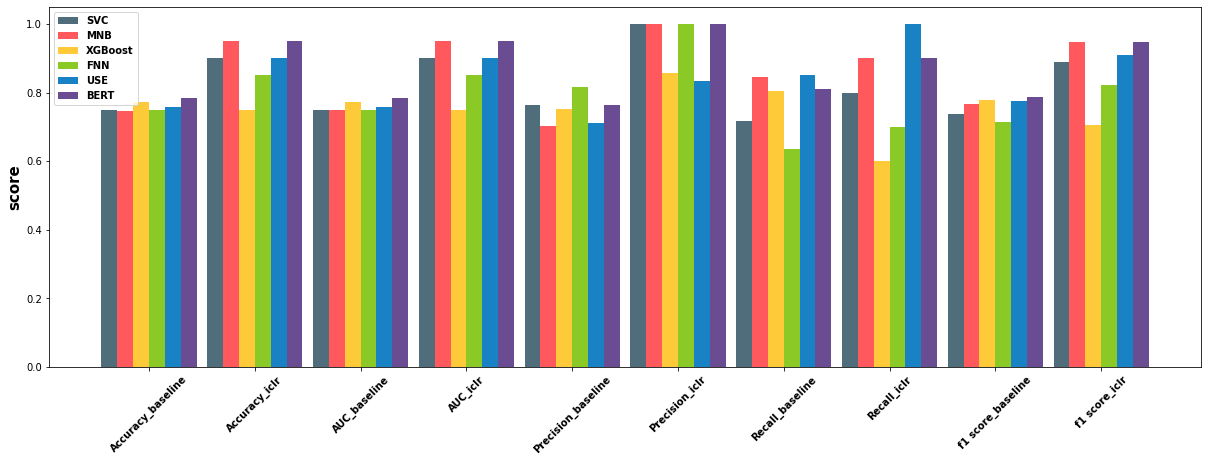

<Figure size 432x288 with 0 Axes>

In [ ]:
"""
PERFORMANCE GRAPH
"""

import numpy as np
import matplotlib.pyplot as plt

# score_list=[model_name,acc_train,acc_test,auc_train,auc_test,prec_train,prec_test,rec_train,rec_test,f1_train,f1_test]
data_keys = ['Accuracy_baseline', 'Accuracy_iclr', 'AUC_baseline', 'AUC_iclr', 'Precision_baseline', 'Precision_iclr', 'Recall_baseline', 'Recall_iclr', 'f1 score_baseline', 'f1 score_iclr']
labels=['SVC', 'MNB', 'XGBoost','FNN', 'USE', 'BERT']

data_lst=[SVC_res,MNB_res,XGB_res,FNN_res,USE_res,BERT_res]
for model_x in data_lst:
  for num in range(len(model_x)):
    model_x[num]=round(model_x[num],4)

X = np.arange(len(data_lst[0]))
fig, ax = plt.subplots(figsize=(16,5))
# fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15)
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15)
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15)
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15)
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15)
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)
ax.legend(labels,prop=dict(weight='bold'))
ax.set_ylabel('score',size='15',fontweight='bold')
# ax.set_xlabel('section',size='15',fontweight='bold')
ax.set_xticks(X+0.375)
ax.set_xticklabels(data_keys,fontweight='bold')
plt.xticks(rotation=45)
pps = [ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15),
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15),
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15),
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15),
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15),
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)]
# for item in pps:
#   for p in item:
#     height = p.get_height()
#     ax.annotate('{}'.format(height),
#         xy=(p.get_x() + p.get_width() / 2, height),
#         xytext=(0, 3), # 3 points vertical offset
#         textcoords="offset points",
#         ha='center', va='bottom',rotation=60)
fig.savefig("/content/drive/MyDrive/ML/innovation_lab/CN_TESTING_model_dist", bbox_inches='tight',pad_inches=0.1) # SAVE PATH FOR GRAPH
plt.show()
plt.clf()

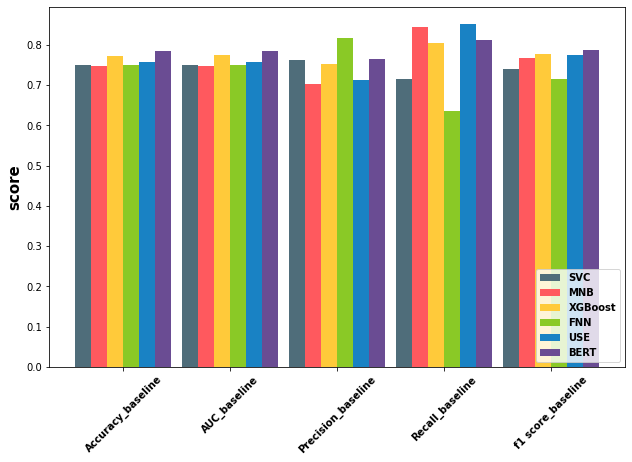

<Figure size 432x288 with 0 Axes>

In [ ]:
"""
PERFORMANCE GRAPH (BASELINE)
"""
import numpy as np
import matplotlib.pyplot as plt

# score_list=[model_name,acc_train,acc_test,auc_train,auc_test,prec_train,prec_test,rec_train,rec_test,f1_train,f1_test]
data_keys = ['Accuracy_baseline', 'AUC_baseline', 'Precision_baseline', 'Recall_baseline', 'f1 score_baseline']
labels=['SVC', 'MNB', 'XGBoost','FNN', 'USE', 'BERT']

data_lst=[SVC_res[::2],MNB_res[::2],XGB_res[::2],FNN_res[::2],USE_res[::2],BERT_res[::2]]
for model_x in data_lst:
  for num in range(len(model_x)):
    model_x[num]=round(model_x[num],4)

X = np.arange(len(data_lst[0]))
fig, ax = plt.subplots(figsize=(8,5))
# fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15)
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15)
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15)
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15)
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15)
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)
ax.legend(labels,prop=dict(weight='bold'),loc='lower right')
ax.set_ylabel('score',size='15',fontweight='bold')
# ax.set_xlabel('section',size='15',fontweight='bold')
ax.set_xticks(X+0.375)
ax.set_xticklabels(data_keys,fontweight='bold')
plt.xticks(rotation=45)
pps = [ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15),
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15),
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15),
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15),
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15),
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)]
# for item in pps:
#   for p in item:
#     height = p.get_height()
#     ax.annotate('{}'.format(height),
#         xy=(p.get_x() + p.get_width() / 2, height),
#         xytext=(0, 3), # 3 points vertical offset
#         textcoords="offset points",
#         ha='center', va='bottom',rotation=60)
fig.savefig("/content/drive/MyDrive/ML/innovation_lab/CN_BASELINE_model_dist", bbox_inches='tight',pad_inches=0.1) # SAVE PATH FOR GRAPH
plt.show()
plt.clf()

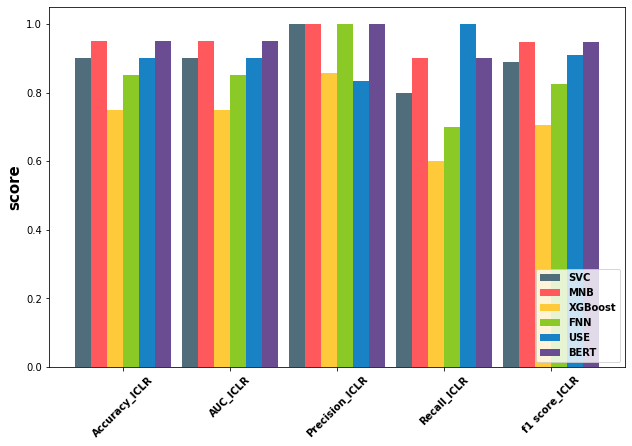

<Figure size 432x288 with 0 Axes>

In [ ]:
"""
PERFORMANCE GRAPH (QUALITATIVE ANALYSIS)
"""

import numpy as np
import matplotlib.pyplot as plt

# score_list=[model_name,acc_train,acc_test,auc_train,auc_test,prec_train,prec_test,rec_train,rec_test,f1_train,f1_test]
data_keys = ['Accuracy_ICLR', 'AUC_ICLR', 'Precision_ICLR', 'Recall_ICLR', 'f1 score_ICLR']
labels=['SVC', 'MNB', 'XGBoost','FNN', 'USE', 'BERT']

data_lst=[SVC_res[1::2],MNB_res[1::2],XGB_res[1::2],FNN_res[1::2],USE_res[1::2],BERT_res[1::2]]
for model_x in data_lst:
  for num in range(len(model_x)):
    model_x[num]=round(model_x[num],4)

X = np.arange(len(data_lst[0]))
fig, ax = plt.subplots(figsize=(8,5))
# fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15)
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15)
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15)
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15)
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15)
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)
ax.legend(labels,prop=dict(weight='bold'),loc='lower right')
ax.set_ylabel('score',size='15',fontweight='bold')
# ax.set_xlabel('section',size='15',fontweight='bold')
ax.set_xticks(X+0.375)
ax.set_xticklabels(data_keys,fontweight='bold')
plt.xticks(rotation=45)
pps = [ax.bar(X + 0.00, data_lst[0], color = '#4f6d7a', width = 0.15),
ax.bar(X + 0.15, data_lst[1], color = '#ff595e', width = 0.15),
ax.bar(X + 0.30, data_lst[2], color = '#ffca3a', width = 0.15),
ax.bar(X + 0.45, data_lst[3], color = '#8ac926', width = 0.15),
ax.bar(X + 0.60, data_lst[4], color = '#1982c4', width = 0.15),
ax.bar(X + 0.75, data_lst[5], color = '#6a4c93', width = 0.15)]
# for item in pps:
#   for p in item:
#     height = p.get_height()
#     ax.annotate('{}'.format(height),
#         xy=(p.get_x() + p.get_width() / 2, height),
#         xytext=(0, 3), # 3 points vertical offset
#         textcoords="offset points",
#         ha='center', va='bottom',rotation=60)
fig.savefig("/content/drive/MyDrive/ML/innovation_lab/CN_ICLR_model_dist", bbox_inches='tight',pad_inches=0.1) # SAVE PATH FOR GRAPH
plt.show()
plt.clf()

In [ ]:
"""
Results:
format = [acc_test,acc_iclr,auc_test,auc_iclr,prec_test,prec_iclr,rec_test,rec_iclr,f1_test,f1_iclr]
SVC_res= [0.75, 0.9, 0.7495554765291608, 0.9, 0.762589928057554, 1.0, 0.7162162162162162, 0.8, 0.7386759581881532, 0.888888888888889] 
MNB_res= [0.7466666666666667, 0.95, 0.7479551920341395, 0.95, 0.702247191011236, 1.0, 0.8445945945945946, 0.9, 0.7668711656441718, 0.9473684210526316] 
XGB_res= [0.7733333333333333, 0.75, 0.7737375533428165, 0.7500000000000001, 0.7531645569620253, 0.8571428571428571, 0.8040540540540541, 0.6, 0.7777777777777778, 0.7058823529411764] 
FNN_res= [0.75, 0.85, 0.7484886201991465, 0.85, 0.8173913043478261, 1.0, 0.6351351351351351, 0.7, 0.7148288973384029, 0.8235294117647058] 
USE_res= [0.7566666666666667, 0.9, 0.7579125177809388, 0.9, 0.711864406779661, 0.8333333333333334, 0.8513513513513513, 1.0, 0.7753846153846154, 0.9090909090909091] 
BERT_res= [0.7833333333333333, 0.95, 0.783694879089616, 0.95, 0.7643312101910829, 1.0, 0.8108108108108109, 0.9, 0.7868852459016394, 0.9473684210526316]
"""